In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score
X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")

def eval_proba(probas,y,n_features, num_target = 1000):
    sorted_probas = np.sort(probas)[::-1]  
    threshold = sorted_probas[num_target - 1]

    y_pred = (probas >= threshold).astype(int)
    gain = 10*precision_score(y, y_pred)*num_target
    return np.round(gain - 200*n_features)

Testy czy są jakieś zmienne widoczne do odsiania na start i nie bardzo. Istotność jest wmiare równomierna.

In [ ]:
import pandas as pd
from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(X_train, y_train)


anova_df = pd.DataFrame({
    'Feature': range(len(f_values)),  
    'f_values': f_values
})
anova_df.sort_values('f_values',ascending=False)

C:\Users\Michał\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,Feature,f_values
2,2,8.166821e+02
3,3,6.520684e+02
6,6,6.475669e+02
7,7,5.715860e+02
4,4,5.569868e+02
...,...,...
466,466,4.922815e-05
53,53,9.563670e-06
448,448,7.627570e-06
296,296,1.133295e-06


RFE + XGBOOST(chyba bez sensu trzeba raczej budować niz redukować)

In [ ]:
import numpy as np
import pandas as pd
from collections import namedtuple
from itertools import product
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
import shap


def evaluate_all_combinations(
        X: pd.DataFrame,
        y,
        feature_counts=(5, 10, 15),
        n_splits: int = 5,
        num_target: int = 1_000,
        random_state: int = 42):

    def l1_logreg(X, y, k):
        model = LogisticRegression(penalty='l1', solver='liblinear', C=0.1)
        model.fit(X, y)
        ranking = np.argsort(np.abs(model.coef_[0]))[::-1]
        return ranking[:k]

    def rf_importance(X, y, k):
        rf = RandomForestClassifier(n_estimators=250, random_state=random_state)
        rf.fit(X, y)
        ranking = np.argsort(rf.feature_importances_)[::-1]
        return ranking[:k]

    def xgb_shap(X, y, k):
        xgb = XGBClassifier(use_label_encoder=False,
                            eval_metric='logloss',
                            random_state=random_state)
        xgb.fit(X, y)
        explainer = shap.TreeExplainer(xgb)
        shap_vals = explainer.shap_values(X.sample(n=min(1_000, len(X)),
                                                   random_state=random_state))
        shap_mean = np.abs(shap_vals).mean(axis=0)
        ranking = np.argsort(shap_mean)[::-1]
        return ranking[:k]

    def mutual_info(X, y, k):
        mi = mutual_info_classif(X, y, random_state=random_state)
        ranking = np.argsort(mi)[::-1]
        return ranking[:k]

    def rfe_logreg(X, y, k):
        rfe = RFE(LogisticRegression(), n_features_to_select=k)
        rfe.fit(X, y)
        return np.where(rfe.support_)[0]

    SELECTORS = {
        "L1-LogReg":        l1_logreg,
        "RF-imp":           rf_importance,
        "XGB-SHAP":         xgb_shap,
        "MutualInfo":       mutual_info,
        "RFE-LogReg":       rfe_logreg,
    }

    CLASSIFIERS = {
        "LogReg": LogisticRegression(max_iter=1_000, random_state=random_state),
        "RandomForest": RandomForestClassifier(
            n_estimators=500, random_state=random_state),
        "GaussianNB": GaussianNB(),
        "XGB": XGBClassifier(use_label_encoder=False,
                             eval_metric='logloss',
                             random_state=random_state),
    }

    Result = namedtuple("Result", "selector clf k n_feats precision score")
    results = []
    skf = StratifiedKFold(
        n_splits=n_splits, shuffle=True, random_state=random_state)
    y_np = np.asarray(y)

    def evaluate_single(X_sel, clf_name, clf):
        """CV + custom profit metric"""
        probas = np.zeros(len(y_np))
        for tr_idx, te_idx in skf.split(X_sel, y_np):
            clf.fit(X_sel.iloc[tr_idx], y_np[tr_idx])
            probas[te_idx] = clf.predict_proba(X_sel.iloc[te_idx])[:, 1]

        thresh = np.sort(probas)[::-1][num_target - 1]
        y_pred = (probas >= thresh).astype(int)
        prec = precision_score(y_np, y_pred)
        return prec

    for (sel_name, sel_fun), k, (clf_name, clf_template) in product(
            SELECTORS.items(), feature_counts, CLASSIFIERS.items()):
        idx = sel_fun(X, y, k)
        X_sub = X.iloc[:, idx]
        clf = clf_template.__class__(**clf_template.get_params())

        prec = evaluate_single(X_sub, clf_name, clf)
        score = prec * 10_000 - X_sub.shape[1] * 200
        results.append(Result(sel_name, clf_name, k,
                              X_sub.shape[1], prec, score))
        print(f"{sel_name:.10} + {clf_name:.12} k={k} | Prec={prec:.4f} | Score={score:.2f}")

    results.sort(key=lambda r: r.score, reverse=True)

    print("\nTOP 10 kombinacji:")
    for r in results[:10]:
        print(f"{r.selector:<10} + {r.clf:<12} k={r.k} | features={r.n_feats:.4f} | prec={r.precision:.4f} |  score{r.score:.2f}")

    return results


In [ ]:
results = evaluate_all_combinations(X_train, y_train, feature_counts=[i for i in range(1, 30, 2)])
# evaluate_all_combinations(X_train, y_train, feature_counts=[2])

L1-LogReg + LogReg k=1 | Prec=0.4990 | Score=4790.00
L1-LogReg + RandomForest k=1 | Prec=0.4746 | Score=4545.76
L1-LogReg + GaussianNB k=1 | Prec=0.4940 | Score=4740.00
L1-LogReg + XGB k=1 | Prec=0.4721 | Score=4520.56
L1-LogReg + LogReg k=3 | Prec=0.5440 | Score=4840.00
L1-LogReg + RandomForest k=3 | Prec=0.4711 | Score=4111.16
L1-LogReg + GaussianNB k=3 | Prec=0.5430 | Score=4830.00
L1-LogReg + XGB k=3 | Prec=0.4990 | Score=4390.00
L1-LogReg + LogReg k=5 | Prec=0.5420 | Score=4420.00
L1-LogReg + RandomForest k=5 | Prec=0.4945 | Score=3945.16
L1-LogReg + GaussianNB k=5 | Prec=0.5490 | Score=4490.00
L1-LogReg + XGB k=5 | Prec=0.5090 | Score=4090.00
L1-LogReg + LogReg k=7 | Prec=0.5320 | Score=3920.00
L1-LogReg + RandomForest k=7 | Prec=0.5040 | Score=3639.60
L1-LogReg + GaussianNB k=7 | Prec=0.5320 | Score=3920.00
L1-LogReg + XGB k=7 | Prec=0.5040 | Score=3640.00
L1-LogReg + LogReg k=9 | Prec=0.5430 | Score=3630.00
L1-LogReg + RandomForest k=9 | Prec=0.5183 | Score=3382.69
L1-LogReg + 

[Result(selector='RF-imp', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='RF-imp', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='XGB-SHAP', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='XGB-SHAP', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='MutualInfo', clf='LogReg', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='MutualInfo', clf='GaussianNB', k=1, n_feats=1, precision=0.729, score=7090.0),
 Result(selector='RF-imp', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='XGB-SHAP', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='MutualInfo', clf='XGB', k=1, n_feats=1, precision=0.7218344965104686, score=7018.344965104686),
 Result(selector='XGB-SHAP', clf='RandomForest', k=3, n_feats=3, precision=0.739, score=6790.0),
 Result(s

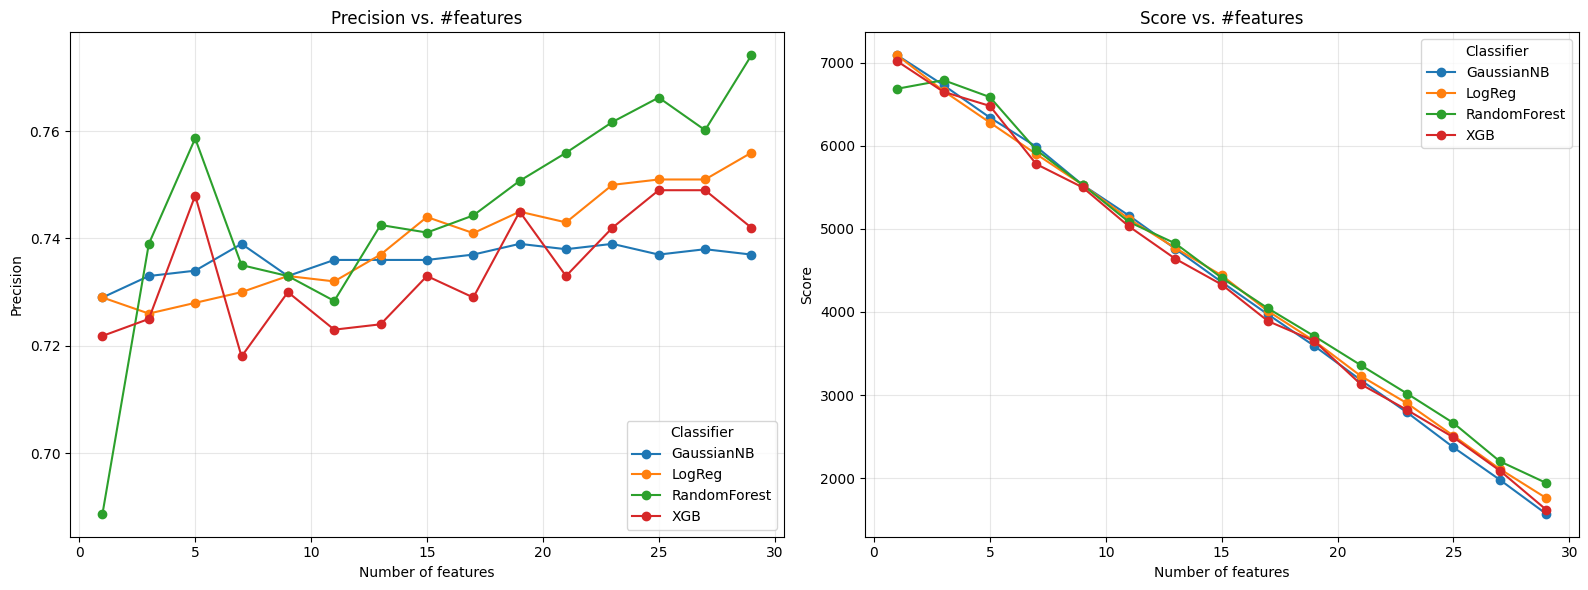

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(results)  
metrics = ["precision", "score"]
fig, axes = plt.subplots(1, len(metrics), figsize=(14, 6), sharex=True)

for metric, ax in zip(metrics, axes):
    for (clf, selector), grp in df.groupby(["clf", "selector"]):
        best = grp.groupby("n_feats")[metric].max().sort_index()
        label = f"{clf} | {selector}"
        ax.plot(best.index, best.values, marker="o", label=label)
    ax.set_xlabel("Number of selected features")
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f"{metric.capitalize()} vs #features")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8, title="Model | Selector")
plt.tight_layout()
plt.show()

In [29]:
def eval_proba(probas,y,n_features, num_target = 1000):
    sorted_probas = np.sort(probas)[::-1]  
    threshold = sorted_probas[num_target - 1]

    y_pred = (probas >= threshold).astype(int)
    gain = 10*precision_score(y, y_pred)*num_target
    return np.round(gain - 200*n_features)

Logistic Regression with forward

In [12]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer, precision_score
from sklearn.preprocessing import StandardScaler

X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")
num_target=1000
n_splits = 5
X_train, y_train = np.array(X_train), np.array(y_train).T[0]

X_train = StandardScaler().fit_transform(X_train)

n_features = X_train.shape[1]

max_features = 10
model = LogisticRegression(max_iter=1000)

selected = []
remaining = list(range(n_features))
best_score = 0
precision = make_scorer(precision_score, zero_division=0)

for _ in range(max_features):
    best_candidate_score = 0
    for i in remaining:
        current_features = selected + [i]
        probas = cross_val_predict(model, X_train[:,current_features], y_train, cv=n_splits, method='predict_proba')[:,1]
        score = eval_proba(probas, y_train,len(current_features))
        if score > best_candidate_score:
            best_candidate = i
            best_candidate_score = score
    
    
    selected.append(best_candidate)
    remaining.remove(best_candidate)
    print(best_candidate_score,selected)



7190.0 [3]
7060.0 [3, 298]
6920.0 [3, 298, 343]
6750.0 [3, 298, 343, 344]
6580.0 [3, 298, 343, 344, 495]
6430.0 [3, 298, 343, 344, 495, 135]
6250.0 [3, 298, 343, 344, 495, 135, 45]
6050.0 [3, 298, 343, 344, 495, 135, 45, 149]
5860.0 [3, 298, 343, 344, 495, 135, 45, 149, 190]
5660.0 [3, 298, 343, 344, 495, 135, 45, 149, 190, 104]


XGboost with anova preselect and backwards, based on RFE

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE

X_train = pd.read_csv("data/x_train.txt",header=None,sep=" ")
y_train = pd.read_csv("data/y_train.txt",header=None,sep=" ")
num_target=1000
n_splits = 5
X_train, y_train = np.array(X_train), np.array(y_train).T[0]
max_features = 10
selected = []
selector = SelectKBest(score_func=f_classif, k=30)
X_train = selector.fit_transform(X_train, y_train)
print("Initial indices", selector.get_support(indices=True))
for n_features in range(max_features, 0,-1):
    best_score = 0
    model = XGBClassifier()
    selector = RFE(estimator=model, n_features_to_select=n_features, step=1, verbose=0)
    selector.fit(X_train, y_train)
    X_selected = selector.transform(X_train)
    probas = cross_val_predict(model, X_selected, y_train, cv=n_splits, method='predict_proba')[:,1]
    score = eval_proba(probas, y_train,n_features)
    
    print(score,selector.get_support(indices=True))

Initial indices [  0   1   2   3   4   5   6   7   8   9 140 170 180 215 293 300 330 332
 336 339 343 344 351 356 366 395 414 425 458 462]
5490.0 [ 2  4  5  8 13 20 22 26 27 29]
5690.0 [ 2  4  5  8 13 22 26 27 29]
5910.0 [ 2  4  5  8 13 26 27 29]
6050.0 [ 2  4  5  8 26 27 29]
6060.0 [ 2  4  5 26 27 29]
6420.0 [ 2  4 26 27 29]
6580.0 [ 2  4 27 29]
6760.0 [ 2  4 29]
6910.0 [2 4]
7128.0 [2]


Mój własny model oparty na odległościach(bardziej clustering niż klasyfikacja, ale działa)

In [14]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator, ClassifierMixin

class kernel_distance_classifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.classes_= [1]
        pass
    
    def fit(self, X_train, y_train):
        self.scaler = StandardScaler().fit(X_train)
        self.X_train = self.scaler.transform(X_train)
        self.y_train = y_train 
        self.y_train[self.y_train==0]=-1
    
    def predict_proba(self, X_test):
        X = self.scaler.transform(X_test)
        dist= cdist(X,self.X_train,metric="euclidean")
        dist = np.exp(-(dist**2)/(2*X.shape[1]))/X.shape[0]
        y_pred = dist@self.y_train
        return 1/(1+ np.exp(-y_pred))
    
    def predict(self, X_test):
        return np.round(self.predict_proba(X_test))
    

In [15]:
import pandas as pd
import numpy as np
X = np.array(pd.read_csv("data/x_train.txt",header=None,sep=" "))
y = np.array(pd.read_csv("data/y_train.txt",header=None,sep=" "))
num_target=1000
max_features = 5
selected = []
remaining = list(range(X.shape[1]))
for _ in range(max_features):
    best_result = 0
    for feature in remaining:
        X_selected = X[:,selected+[feature]]
        model = kernel_distance_classifier()
        y_pred =cross_val_predict(model, X_selected, y, cv=5, method='predict_proba')
        result = eval_proba(y_pred,y,X_selected.shape[1])
        if result > best_result:
            best_feature = feature
            best_result = result
    remaining.remove(best_feature)
    selected.append(best_feature)
    print(best_result, selected)

6819.0 [8]
6786.0 [8, 121]
6737.0 [8, 121, 336]
6702.0 [8, 121, 336, 152]
6561.0 [8, 121, 336, 152, 285]


Cross-val predicted precision 0.6966


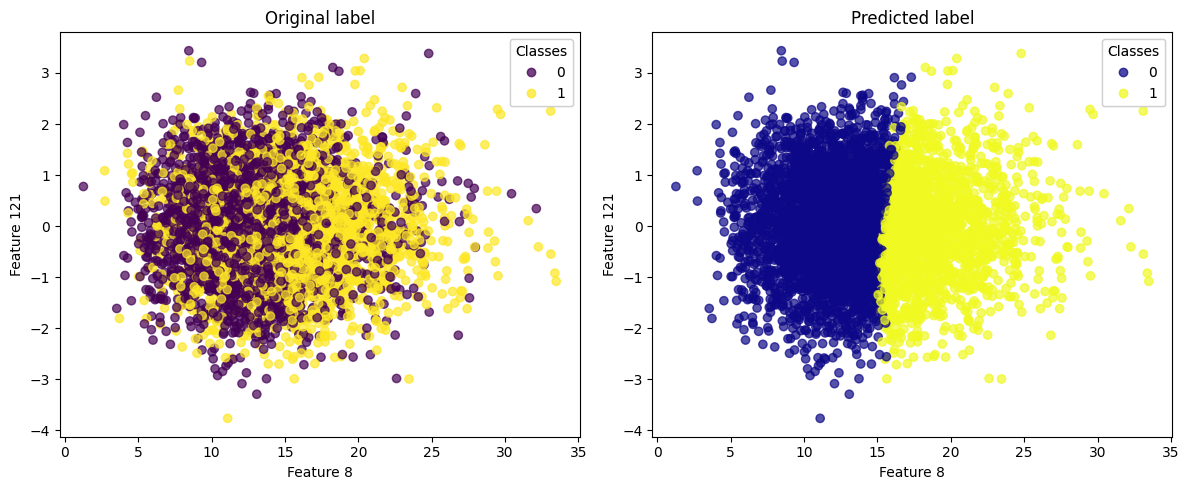

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

X = np.array(pd.read_csv("data/x_train.txt",header=None,sep=" "))
y = np.array(pd.read_csv("data/y_train.txt",header=None,sep=" "))
X_selected = X[:,[8,121]]
model = kernel_distance_classifier()
y_pred  = cross_val_predict(model, X_selected, y, cv=5, method='predict')
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

scatter1 = axes[0].scatter(X_selected[:, 0], X_selected[:, 1], c=y, cmap='viridis', alpha=0.7)
axes[0].set_title("Original label")
axes[0].set_xlabel("Feature 8")
axes[0].set_ylabel("Feature 121")
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Classes")
axes[0].add_artist(legend1)

scatter2 = axes[1].scatter(X_selected[:, 0], X_selected[:, 1], c=y_pred, cmap='plasma', alpha=0.7)
axes[1].set_title("Predicted label")
axes[1].set_xlabel("Feature 8")
axes[1].set_ylabel("Feature 121")
legend2 = axes[1].legend(*scatter2.legend_elements(), title="Classes")
axes[1].add_artist(legend2)

print("Cross-val predicted precision", np.round(precision_score(y,y_pred),4))
plt.tight_layout()
plt.show()